### 1. Import package 

In [1]:
import os, sys
sys.path.append('../src/')
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
import shap
from activityFeature_engineer import *
from pred_model import *
from AppAct_df import *

### ignore the warnings ###

/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2. Load data of app activities

In [2]:
data_dir = '../data/S3/AppEventData/'
CommunityMember, SubscriptionHistory, ActivityComplete, SessionCompleted, \
LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed = process_AppAct_df (data_dir)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


### 3. Sample trial users

##### 3.1 Remove Legacy/Hubspot and Administrator users

In [3]:
CommunityMember_filter = CommunityMember[CommunityMember['membershipName'] != 'Legacy']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Administrator']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Hubspot']
CommunityMember_filter_id = CommunityMember_filter.user.unique()
print (CommunityMember_filter[CommunityMember_filter['membershipSource']=='Unknown'].shape[0], \
       CommunityMember_filter[CommunityMember_filter['membershipSource']!='Unknown'].shape[0])

53009 2269


##### 3.2 Select users with purchase and users with free trials

In [4]:
SubscriptionHistory_purchase = SubscriptionHistory[SubscriptionHistory.event == 'subscription-purchase']
SubscriptionHistory_freeTrial = SubscriptionHistory[SubscriptionHistory.event == 'subscription-free-trial']
SubscriptionHistory_purchase_id = SubscriptionHistory_purchase.user.unique()
SubscriptionHistory_freeTrial_id = SubscriptionHistory_freeTrial.user.unique()
print (f'{len(SubscriptionHistory_purchase_id)} purchase users, {len(SubscriptionHistory_freeTrial_id)} trial users, \
{len(set(SubscriptionHistory_purchase_id).intersection(SubscriptionHistory_freeTrial_id))} intersected')

1559 purchase users, 1629 trial users, 712 intersected


##### 3.3 Select users with purchase converted from trial

In [5]:
convertedFromTrial_id = SubscriptionHistory[SubscriptionHistory.convertedFromTrial == bool('True')].user.unique()
nonconverted_trial = set(SubscriptionHistory_freeTrial_id).difference(SubscriptionHistory_purchase_id)
converted_trial = set(SubscriptionHistory_freeTrial_id).intersection(SubscriptionHistory_purchase_id).intersection(convertedFromTrial_id)
print (f'{len(nonconverted_trial)} nonconverted trial users, {len(converted_trial)} converted trial users')

917 nonconverted trial users, 707 converted trial users


##### 3.4 Select trial users that are not Legacy/Hubspot/Admin

In [6]:
nonconverted = nonconverted_trial.intersection(CommunityMember_filter_id)
converted = converted_trial.intersection(CommunityMember_filter_id)
print (f'Filtering the Legacy and Admin users: {len(nonconverted)} nonconverted, {len(converted)} converted')
IDs = list(nonconverted) + list(converted)

Filtering the Legacy and Admin users: 864 nonconverted, 698 converted


##### 3.5 Commenters

In [9]:
comment_df_all = pd.read_csv('../data/S3/TextData/postgres_Comment.csv', index_col = 0)
comment_df_all.createdAt =  pd.to_datetime(comment_df_all.createdAt).dt.normalize()
comment_df_filterdate = comment_df_all[comment_df_all.createdAt>='2019-08-04']
print (f'Remove {(comment_df_all.shape[0] - comment_df_filterdate.shape[0])} comment events before the first date of ios app')

Remove 451 comment events before the first date of ios app


In [10]:
case2remove = list(comment_df_all[comment_df_all.createdAt<'2019-08-04'].owner.unique())
comment_df = comment_df_filterdate[~comment_df_filterdate.owner.isin(case2remove)]
print (f'{len(case2remove)} cases with comment events before the app start date \n \
       remove {comment_df_filterdate.shape[0] - comment_df.shape[0]} rows')

63 cases with comment events before the app start date 
        remove 2465 rows


In [16]:
owner = comment_df.owner.unique()
print (f'{len(owner)} commenters')
print (f'{len(set(SubscriptionHistory_purchase_id).intersection(owner))} general subscribers with comments')
CommunityMember[CommunityMember.user.isin(owner)].groupby(['membershipName'], dropna = False).agg(['count'])

720 commenters
137 general subscribers with comments


,user,createdAt,goal,exp,membershipSource
,count,count,count,count,count
membershipName,,,,,
12 Months,97,97,97,97,97
Legacy,247,247,247,246,247
Monthly,42,42,42,42,42
NaN,318,318,317,318,318


## 4. EDA

##### 4.1 Comment frequency by membership categories

                createdAt                       
                     mean median min   max count
membershipName                                  
12 Months        6.082474      2   1   126    97
Legacy          16.125506      2   1  1453   247
Monthly         14.142857      2   1   242    42
Non-sub          2.795597      1   1   155   318
X axis is the comment freq; y is the number of users with the given freq


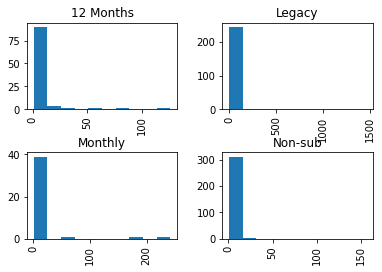

In [22]:
CommentFreq = comment_df.groupby(['owner']).agg('count')
CommunityMember_comment = CommunityMember[CommunityMember.user.isin(owner)]
CommentFreq_member = (CommunityMember_comment[['user','membershipName']].
                      set_index('user')).join(CommentFreq.drop(['_id', 'text'], axis = 1))
CommentFreq_member.membershipName = CommentFreq_member.membershipName.fillna('Non-sub')
print (CommentFreq_member.groupby(['membershipName']).agg(['mean', 'median', 'min', 'max', 'count']))
CommentFreq_member['createdAt'].hist(by=CommentFreq_member['membershipName'])
print ('X axis is the comment freq; y is the number of users with the given freq')

###### 4.2 How long does it takes from the first comment to become a premium user?

In [39]:
# get the first date of commenting
sub_commenter_id = list(CommentFreq_member[CommentFreq_member.membershipName.isin(['12 Months', 'Monthly'])].index)
subComment_df = pd.DataFrame(columns=['owner', 'createdAt'])
for i in sub_commenter_id:
    selected_row = comment_df[comment_df['owner'] == i][['owner', 'createdAt']].sort_values(by=['createdAt']).iloc[0,:]
    subComment_df = subComment_df.append(selected_row)
subComment_df = subComment_df.rename(columns = {'owner': 'user', 'createdAt': 'eventDate'})

In [41]:
# get the first date of becoming a premium user
subDate_df = pd.DataFrame(columns = ['user', 'event', 'eventDate'])
for i in sub_commenter_id:
    try:
        sub_start = SubscriptionHistory[(SubscriptionHistory['user'] == i)& \
                    (SubscriptionHistory['event'].isin(['subscription-free-trial', 'subscription-purchase']))]. \
                    sort_values(by=['eventDate']).iloc[0,:][['user', 'event', 'eventDate']]
    except:
        pass
    subDate_df = subDate_df.append(sub_start)

In [43]:
substract = subDate_df.set_index('user').drop(columns=['event']). \
subtract(subComment_df.set_index('user'), fill_value=0)

In [44]:
substract

,eventDate
user,
00ad2cdc-e7a6-4ecd-ba9b-331724b5280d,5 days
02366548-8603-4372-9603-38ee7138b57b,-17 days
0270e956-675d-442c-ac9e-4af28983553e,-21 days
04449a75-dfd3-471d-b188-8e1118447f67,0 days
074009a6-dd17-4e38-b0dc-2e315f937729,-204 days
...,...
f9946d46-0b26-444c-bf9f-d6322c0c0ce7,32 days
fc498b17-2424-4693-8499-d1f946b6b0e0,-323 days
fca7c2c1-77ae-42c5-8388-7b574fdfab18,-9 days


### 4. EAD: How many days before trials?

In [ ]:
b4Trial_dict = {}
for ID in IDs:
    trial_start = pd.to_datetime(SubscriptionHistory[(SubscriptionHistory['user']==ID)&(SubscriptionHistory['event']=='subscription-free-trial')]['eventDate'].values)
    create_date = pd.to_datetime(CommunityMember[(CommunityMember['user']==ID)]['createdAt'].values)
    b4Trial_dict[ID] = (trial_start-create_date).days.values[0]
    
b4Trial_df = pd.DataFrame(list(b4Trial_dict.items()), columns = ['user', 'days_create2Trial']).set_index(['user'])
b4Trial_df['Converted'] = bool(True)
b4Trial_df.loc[list(nonconverted), 'Converted'] =  bool(False)

# print ('Trial users whose subscribe before creation date')
# print (b4Trial_df[b4Trial_df.days_create2Trial < 0])

b4Trial_filter = b4Trial_df[(b4Trial_df.days_create2Trial > 0)]
print ('Users that created an account before trial')
print (b4Trial_filter.groupby(['Converted']).agg(['count']), '\n')

print ('The number of days before trial of these users \n X-axis = number of days before trials \n y-axis = freq')
print (b4Trial_filter.days_create2Trial.hist(by=b4Trial_filter.Converted))

## 5. Feature engineering

In [ ]:
# During trial: freq, cons
DFs = ActivityComplete, SessionCompleted, LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed
trial_activity = feature_duration(DFs, IDs, SubscriptionHistory)

In [ ]:
# During first 2 days of trial: freq
DFs = trial_activity['ActivityComplete']['filter'], trial_activity['SessionCompleted']['filter'], \
trial_activity['LibrarySelectedTab']['filter'], trial_activity['ScreenViewed']['filter'], \
trial_activity['AppForeground']['filter'], trial_activity['SessionViewed']['filter']
trial2_activity = feature_duration(DFs, IDs, SubscriptionHistory, duration = 3, consecutive = False)

In [ ]:
# Before trial: freq, daily ave, norm
DFs = ActivityComplete, SessionCompleted, LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed
b4_activity = feature_duration(DFs, IDs, SubscriptionHistory, add = False, consecutive = False, cal_ave = True, dayDF = b4Trial_filter)

In [ ]:
# 7 days before and 7 days during trial: cons
DFs = pd.concat([trial_activity['ActivityComplete']['filter'], b4_activity['ActivityComplete']['filter']]), \
pd.concat([trial_activity['SessionCompleted']['filter'], b4_activity['SessionCompleted']['filter']]), \
pd.concat([trial_activity['LibrarySelectedTab']['filter'], b4_activity['LibrarySelectedTab']['filter']]), \
pd.concat([trial_activity['ScreenViewed']['filter'], b4_activity['ScreenViewed']['filter']]), \
pd.concat([trial_activity['AppForeground']['filter'], b4_activity['AppForeground']['filter']]), \
pd.concat([trial_activity['SessionViewed']['filter'], b4_activity['SessionViewed']['filter']])

b4_duringTrial_activity = feature_duration(DFs, IDs, SubscriptionHistory, filter = False, freq = False)

## 6. Feature dataframe
Column 'Converted': True = converted, False = nonconverted 

In [ ]:
# Converted/Churned Trial Users - Select users that do not have ambiguous days before trial
feature_df = b4Trial_df[(b4Trial_df.days_create2Trial >= 0)]

In [ ]:
# Features: Goal & Experience
CommunityMember_join = CommunityMember[['user','goal', 'exp']].set_index('user')
feature_df = feature_df.join(CommunityMember_join)
feature_df = feature_df[feature_df.goal.notnull()]
feature_df = feature_df[feature_df.exp.notnull()]
# one hot encoding
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['goal'], prefix='goal')],axis=1)
feature_df.drop(['goal'],axis=1, inplace=True)
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['exp'], prefix='exp')],axis=1)
feature_df.drop(['exp'],axis=1, inplace=True)

In [ ]:
# Append app activity features
def append_feature_df (feature, pre_column, renamed_column, feature_df):
    feature_renamed = feature.rename(columns={pre_column:renamed_column})
    feature_df_new = feature_df.join(feature_renamed[renamed_column])
    return feature_df_new
    
def iterate_feature_type (df, df_name, feature_df, feature_types= [('norm', 'normed_daily_ave'), \
('cons', 'number_consecutive_day'), ('ave', 'daily_ave'), ('freq', 'count')]):
    for activity_name in df:
        for metrics, metric_name in feature_types:
            try:
                feature = df[activity_name][metrics]
                new_name = df_name+'_'+ activity_name+'_'+metrics
                feature_df = append_feature_df (feature, metric_name, new_name, feature_df)
            except:
                pass
    return feature_df
            
feature_df_new = iterate_feature_type (b4_activity, 'b4Trial', feature_df)
feature_df_new = iterate_feature_type (trial_activity, '7dTrial', feature_df_new)
feature_df_new = iterate_feature_type (trial2_activity, '2dTrial', feature_df_new)
feature_df_new = iterate_feature_type (b4_duringTrial_activity, 'b4_duringTrial', feature_df_new)

feature_df_new = feature_df_new.fillna(0)
feature_df_new.shape

## 7. Model selection and tuning

In [ ]:
# define datasets
try:
    X= pd.read_csv('../results/X', index_col='user')
    y = pd.read_csv('../results/y', index_col='user')['Converted']
    print ('load the precomputed X and y')
except:
    X = feature_df_new.loc[:,feature_df_new.columns!='Converted']
    y = feature_df_new['Converted']
    X = X.astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### 5-fold cross validation, accompanied with Recursive Feature Elimination 

In [ ]:
def get_models():
	models = dict()
    # decision tree
	rfe = RFECV(estimator=DecisionTreeClassifier())
	model = DecisionTreeClassifier()
	models['Decision Tree'] = Pipeline(steps=[('s',rfe),('m',model)])
    # lr
	rfe = RFECV(estimator=LogisticRegression())
	model = LogisticRegression()
	models['Logistic Regression'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFECV(estimator=RandomForestClassifier())
	model = RandomForestClassifier()
	models['Random Forest'] = Pipeline(steps=[('s',rfe),('m',model)])
    # XGB
	rfe = RFECV(estimator=XGBClassifier())
	model = XGBClassifier()
	models['XG Boost'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
plt.boxplot(results[1:4], labels=names[1:4], showmeans=True)
plt.ylabel('Accuracy', fontsize = 10)
plt.xticks(fontsize = 10)
plt.savefig('../results/RFECV_models.png', dpi = 400, transparent = True)
plt.show()

##### Grid search for hyperparameters

In [ ]:
# baseline model without Recursive feature elimination
rfc=RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
baseline_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
baseline_rfc.fit(X_train, y_train)
y_pred_baseline = baseline_rfc.predict(X_test)
print ('best parameter: ', baseline_rfc.best_params_)
plot_AUC(baseline_rfc, X_test, y_test)

In [ ]:
# Grid search for hyperparameters
# Random forest with Recursive feature elimination
rfcv = RFECV(estimator=RandomForestClassifier(random_state = 0))
rfcv.fit(X_train, y_train)
rf_feature = X_train.columns[rfcv.support_]
rfc=RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train[rf_feature], y_train)
y_pred_rf = CV_rfc.predict(X_test[rf_feature])
print ('best parameter: ', CV_rfc.best_params_)
print (len(rf_feature), 'selected features')
plot_AUC(CV_rfc, X_test[rf_feature], y_test)

## 8. Interpreting the model

In [ ]:
rf=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 100, max_depth=8, criterion='gini', oob_score = True)
selector = rf.fit(X_train[rf_feature], y_train)

In [ ]:
perm = PermutationImportance(rf, random_state=1).fit(X_test[rf_feature], y_test)
perm_imp_eli5 = imp_df(list(rf_feature), perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance', y_sz=1)
eli5.show_weights(perm, feature_names = list(rf_feature))

In [ ]:
var_imp_plot(perm_imp_eli5.head(20), 'Permutation feature importance_top20', y_sz=8)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(selector)
shap_values = explainer.shap_values(X_test[rf_feature])
f = plt.figure()
shap.summary_plot(shap_values[1], X_test[rf_feature])
f.savefig('../results/shap.png', bbox_inches='tight', dpi=600)

In [ ]:
shap.dependence_plot('b4Trial_ScreenViewed_freq', shap_values[1], X_test[rf_feature], interaction_index="7dTrial_SessionViewed_freq")

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test[rf_feature])

In [ ]:
### to save the plot by matplotlib, uncomment the following statements ###
# plt.clf()
# shap.initjs()
instance_to_explain = 258
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_to_explain], 
                X_test[rf_feature].iloc[instance_to_explain])#, matplotlib=True,show=False)
# plt.savefig('../results/shap_eg1.png', dpi=600, transparent = True)

In [ ]:
'''
# save datafranes
X.to_csv('../results/X')
y.to_csv('../results/y')
'''

## 7. Predictive models for converted/churned trial users

In [ ]:
# X and y, train and test sets
X = feature_df_new.loc[:,feature_df_new.columns!='Converted'][sel_drop]
y = feature_df_new['Converted']
X = X.astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Grid search for hyperparameters
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5) #stratified CV, CV k-fold = 10, one for all
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

In [ ]:
# A model with the best performing hyperparameters
rf=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=8, criterion='entropy', oob_score = True)
selector = rf.fit(X_train, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Test Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_test, y_test)))

# AUCs
plot_AUC(selector, X_test, y_test)

In [ ]:
# Feature importance
perm = PermutationImportance(selector, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
var_imp_plot4(perm_imp_eli5, 'Permutation feature importance (eli5)')

base_imp = imp_df(X_train.columns, rf.feature_importances_)
var_imp_plot4(base_imp, 'Default feature importance (sklearn)')

drop_imp = drop_col_feat_imp(selector, X_train, y_train)
var_imp_plot(drop_imp, 'Drop Column feature importance')

extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2) 
extra_tree_forest.fit(X_train, y_train) 
feature_importance = extra_tree_forest.feature_importances_ 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0) 
df_fi = pd.DataFrame(list(zip(X.columns, feature_importance_normalized)), columns=['feature','feature_importance'])
df_fi = df_fi.sort_values(by=['feature_importance'], ascending = False)
var_imp_plot(df_fi, 'Extra Tree feature importance')

In [ ]:
# retrain the model on the whole dataset
selector = rf.fit(X, y)
plot_AUC(selector, X, y)

perm = PermutationImportance(selector, cv = None, refit = False, n_iter = 50).fit(X, y)
perm_imp_eli5 = imp_df(X.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

base_imp = imp_df(X.columns, rf.feature_importances_)
var_imp_plot(base_imp, 'Default feature importance (sklearn)')

drop_imp = drop_col_feat_imp(selector, X, y)
var_imp_plot(drop_imp, 'Drop Column feature importance 3')

extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2) 
extra_tree_forest.fit(X, y) 
feature_importance = extra_tree_forest.feature_importances_ 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0) 
df_fi = pd.DataFrame(list(zip(X.columns, feature_importance_normalized)), columns=['feature','feature_importance'])
df_fi = df_fi.sort_values(by=['feature_importance'], ascending = False)
var_imp_plot(df_fi, 'Extra Tree feature importance')

In [ ]:
'''
# decision path
estimator = rf.estimators_[2]
plot_decisionPath(estimator, X, class_name = ['Churned', 'Converted'])
'''

In [ ]:
'''
# select what features to keep based on feature importance
sel_extraTree = list(df_fi[df_fi.feature_importance > 0].feature)
sel_perm = list(perm_imp_eli5[perm_imp_eli5.feature_importance > 0].feature) 
sel_drop = list(drop_imp[drop_imp.feature_importance > 0].feature)
'''

In [ ]:
'''
# recursive feature elimination 
rfe_dict = {}
for i in range(1,50):
    selector = RFE(rf, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, y_train)
    probs = selector.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rfe_dict[i] = roc_auc
lists = sorted(rfe_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
selector = RFE(rf, n_features_to_select=6, step=1)
selector = selector.fit(X_train, y_train)
selected_features = X.columns[selector.support_]

plt.plot(x,y)
plt.xlabel('Number of features')
plt.ylabel('AUROC')
plt.savefig('../results/RFE_AUROC.png', dpi=800, transparent = True)
'''

In [ ]:
'''
# save datafranes
drop_imp.to_csv('../results/drop_imp_whole')
X.to_csv('../results/X')
y.to_csv('../results/y')
feature_df_new.to_csv('../results/feature_df_new')
'''

## 8. Model comparisons

In [ ]:
# X and y, train and test sets
X = feature_df_new.loc[:,feature_df_new.columns!='Converted'][sel_drop]
y = feature_df_new['Converted']
X = X.astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Grid search for hyperparameters
# Random forest
rfc=RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
y_pred_rf = CV_rfc.predict(X_test)

# Logistic regression
clf = LogisticRegression(max_iter=10000)
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_train, y_train)
y_pred_logistic = grid_clf_acc.predict(X_test)

# XG Boost
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
y_pred_xgboost = gsearch4.predict(X_test)

print('Random Forest\n')
print_metrics(y_test, y_pred_rf)
print ('Logictic Regression\n')
print_metrics(y_test, y_pred_logistic)
print ('XG Boost\n')
print_metrics(y_test, y_pred_xgboost)

In [ ]:
grid_clf_acc.best_params_

In [ ]:
lg = LogisticRegression(max_iter=10000, C = 0.01, penalty='l2')
selector = lg.fit(X_train, y_train)
plot_AUC(selector, X_test, y_test)

In [ ]:
rf=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=8, criterion='entropy', oob_score = True)
selector = rf.fit(X_train, y_train)
explainer = shap.TreeExplainer(selector)
shap_values = explainer.shap_values(X)
f = plt.figure()
shap.initjs()
shap.summary_plot(shap_values, X)
f.savefig('../results/shap.png', bbox_inches='tight', dpi=600)

In [ ]:
shap.summary_plot(shap_values[0], X)

In [ ]:
instance_to_explain = 3
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_to_explain], X_test.iloc[instance_to_explain])